In [1]:
import os
import time
import gym
import numpy as np

from keras import optimizers
from keras import backend as K
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#16*16의 단위행렬 생성.
# [x:x+1]로 한 경우 결과적으로 범위는 x
def one_hot(x):
    return np.identity(16)[x:x+1].astype(np.float32)

In [7]:
env = gym.make('FrozenLake-v0')

# Set Q-learning parameters
num_episodes = 2000
learning_rate = 0.1
dis = .99

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n

# weight 기존코드
# W = tf.Variable(tf.random.uniform([input_size, output_size], 0, 0.01), dtype=tf.float32)

# from keras import backend as K로 정의. 기존 코드와 비교했을 때 상당히 유사함
W = K.variable(K.random_uniform_variable(shape = (input_size, output_size), low = 0, high = 0.1), dtype= "float32")

# 기존코드 - 케라스코드에서 차이가 거의 없음
# optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
optimizer = keras.optimizers.SGD(lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
start_time = time.time()
# rewards per episode
rList = []
for i in range(num_episodes):
    # Reset environment and get first new observation
    state = env.reset()
    rAll = 0
    done = False
    local_loss = []

    e = 1. / ((i / 50) + 10)
    # The Q-Table learning algorithm
    while not done:
        # Choose an action by greedly (with a chance of random action)
        # from the Q-network
        # q_value = np.matmul(one_hot(state), W)
        # 위에 적어둔 코드는 작동하지 않음. 찾아보니 tf.matmul은 3차원 이상의 텐서도 계산가능하다고함
        # 넘파이 matmul은 텐서플로우 matmul과 달리 작동하지 않는 것으로 추정
        # 이에 대한 해답을 주는 자료는 찾을 수 없음
        q_value = tf.matmul(one_hot(state), W)
        q_value = np.array(q_value.numpy())

        # e greedy
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_value)

        # Get new state and reward from environment
        state_next, reward, done, _ = env.step(action)
        if done:
            # Update Q, and no q_value+1, since it's action termial state
            q_value[0, action] = reward
        else:
            # Obtain the Q_s` values by feeding the new state through our network
            q_score_next = np.matmul(one_hot(state_next), W)
            # Update Q
            q_value[0, action] = reward + dis * np.max(q_score_next)

        # K.sum(input_value)
        # loss = lambda: K.sum(K.square(q_value - np.matmul(one_hot(state), W)))
        # 위의 loss를 구하는 것은 당장은 작동이 되나 밑의 optimizer.minimize 부분에서 막힘
        # reduce_sum과 sum의 기능이 거의 유사함에도 작동이 되지 않은 것으로 볼 때
        # reduce_sum과 sum에는 분명한 차이가 있는 것으로 보임.
        # tf.matmul과 np.matmul 을 돌렸을 때 실행은 가능하지만
        # 해당 셀 16번째 줄부터 tf.matmul에 대한 이유로 tf.matmul을 사용하는 것이 바람직한 것 같음
        loss = lambda: tf.reduce_sum(input_tensor=tf.square(q_value - tf.matmul(one_hot(state), W)))

        # optimizer, loss will be updated to lower
        # 처음 이 부분에서 오류가 났을 때 두 개의 인자를 하나씩 빼 보았지만 실행되지 않았음
        optimizer.minimize(loss, var_list = W)

        rAll += reward
        state = state_next
    rList.append(rAll)

305.7996985912323 seconds
Success rate: 0.456


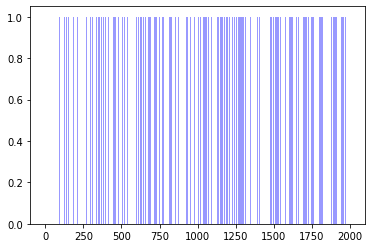

In [10]:
print(f'{(time.time() - start_time)} seconds')
print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()